# Forecasting Multimodal de Celo en Ganado Bovino
## Predicción usando Machine Learning con múltiples features

Este notebook usa Random Forest y XGBoost para predecir el próximo celo considerando TODAS las características disponibles.

## 1. Importar Librerías

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, date

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


## 2. Cargar Datos

In [88]:
# Cargar heat_events
df_heat = pd.read_csv('synthetic_heat_events.csv')
df_heat['heat_date'] = pd.to_datetime(df_heat['heat_date'])

# Cargar cattle para obtener características adicionales
df_cattle = pd.read_csv('synthetic_cattle.csv')
df_cattle['birth_date'] = pd.to_datetime(df_cattle['birth_date'])
df_cattle['fecha_ultimo_parto'] = pd.to_datetime(df_cattle['fecha_ultimo_parto'])

print(f"📊 Datos cargados:")
print(f"   - Heat events: {len(df_heat)} registros")
print(f"   - Cattle: {len(df_cattle)} animales")

df_heat.head()

📊 Datos cargados:
   - Heat events: 422 registros
   - Cattle: 90 animales


,id,cattle_id,heat_date,allows_mounting,vaginal_discharge,vulva_swelling,comportamiento,was_inseminated,insemination_date,pregnancy_confirmed,created_at,updated_at
0,0c8a2951-d536-4191-886e-f326eada868e,508570c8-a218-4761-9402-bba87740b874,2025-02-24,False,seco,leve,olfatea,False,NaN,NaN,2025-12-15 06:02:56.956017,2025-12-15 06:02:56.956017
1,4cc5ecdb-7034-4843-a843-6b402ba08434,508570c8-a218-4761-9402-bba87740b874,2025-03-13,True,cristalino,leve,olfatea,False,NaN,NaN,2025-12-15 06:02:56.956017,2025-12-15 06:02:56.956017
2,aa1ad47b-fb9a-45b9-b79f-9d49db4c4985,508570c8-a218-4761-9402-bba87740b874,2025-04-02,True,turbio,normal,lame_genitales,False,NaN,NaN,2025-12-15 06:02:56.956017,2025-12-15 06:02:56.956017
3,932571e6-f64b-4950-b5fb-5bf8f7917758,508570c8-a218-4761-9402-bba87740b874,2025-04-21,True,seco,leve,nerviosismo,False,NaN,NaN,2025-12-15 06:02:56.956017,2025-12-15 06:02:56.956017
4,5982535d-15aa-4c8a-a4c0-0c99d16b4cb0,508570c8-a218-4761-9402-bba87740b874,2025-05-08,True,seco,leve,monta_a_otras,True,2025-05-08,False,2025-12-15 06:02:56.956017,2025-12-15 06:02:56.956017


## 3. Feature Engineering - Crear Features Multimodales

In [89]:
# Merge heat_events con cattle
df_merged = df_heat.merge(df_cattle[['id', 'birth_date', 'weight', 'fecha_ultimo_parto', 'breed']], 
                          left_on='cattle_id', right_on='id', how='left')

df_merged['age_days'] = (df_merged['heat_date'] - df_merged['birth_date']).dt.days
df_merged['days_since_last_birth'] = (df_merged['heat_date'] - df_merged['fecha_ultimo_parto']).dt.days
df_merged['days_since_last_birth'] = df_merged['days_since_last_birth'].fillna(0)

df_merged = df_merged.sort_values(['cattle_id', 'heat_date'])

# TARGET: Calcular días hasta PRÓXIMO celo (solo para entrenamiento)
df_merged['next_heat_date'] = df_merged.groupby('cattle_id')['heat_date'].shift(-1)
df_merged['days_to_next_heat'] = (df_merged['next_heat_date'] - df_merged['heat_date']).dt.days

# FEATURES: Solo usar PASADO (lag -1, -2, -3)
for lag in [1, 2, 3]:
    df_merged[f'allows_mounting_lag{lag}'] = df_merged.groupby('cattle_id')['allows_mounting'].shift(lag)
    df_merged[f'vaginal_discharge_lag{lag}'] = df_merged.groupby('cattle_id')['vaginal_discharge'].shift(lag)
    df_merged[f'vulva_swelling_lag{lag}'] = df_merged.groupby('cattle_id')['vulva_swelling'].shift(lag)
    df_merged[f'comportamiento_lag{lag}'] = df_merged.groupby('cattle_id')['comportamiento'].shift(lag)

# Calcular intervalos PASADOS
df_merged['prev_heat_date_1'] = df_merged.groupby('cattle_id')['heat_date'].shift(1)
df_merged['prev_heat_date_2'] = df_merged.groupby('cattle_id')['heat_date'].shift(2)

df_merged['interval_lag1'] = (df_merged['heat_date'] - df_merged['prev_heat_date_1']).dt.days
df_merged['interval_lag2'] = (df_merged['prev_heat_date_1'] - df_merged['prev_heat_date_2']).dt.days

df_merged['avg_last_2_intervals'] = (df_merged['interval_lag1'] + df_merged['interval_lag2']) / 2

# Encoding
le_discharge = LabelEncoder()
le_swelling = LabelEncoder()
le_comportamiento = LabelEncoder()
le_breed = LabelEncoder()

for lag in [1, 2, 3]:
    all_discharge = df_merged[f'vaginal_discharge_lag{lag}'].fillna('unknown')
    all_swelling = df_merged[f'vulva_swelling_lag{lag}'].fillna('unknown')
    all_comportamiento = df_merged[f'comportamiento_lag{lag}'].fillna('unknown')
    
    if lag == 1:
        le_discharge.fit(all_discharge)
        le_swelling.fit(all_swelling)
        le_comportamiento.fit(all_comportamiento)
        le_breed.fit(df_merged['breed'].fillna('unknown'))
    
    df_merged[f'vaginal_discharge_lag{lag}_encoded'] = le_discharge.transform(all_discharge)
    df_merged[f'vulva_swelling_lag{lag}_encoded'] = le_swelling.transform(all_swelling)
    df_merged[f'comportamiento_lag{lag}_encoded'] = le_comportamiento.transform(all_comportamiento)
    df_merged[f'allows_mounting_lag{lag}_int'] = df_merged[f'allows_mounting_lag{lag}'].fillna(0).astype(int)

df_merged['breed_encoded'] = le_breed.transform(df_merged['breed'].fillna('unknown'))

print("✅ Features del PASADO creadas correctamente")

✅ Features del PASADO creadas correctamente


## 4. Preparar Dataset para Entrenamiento

In [90]:
feature_columns = [
    # Características de la vaca
    'age_days', 'weight', 'days_since_last_birth', 'breed_encoded',
    
    # Lag 1 (celo anterior inmediato)
    'allows_mounting_lag1_int', 'vaginal_discharge_lag1_encoded',
    'vulva_swelling_lag1_encoded', 'comportamiento_lag1_encoded',
    
    # Lag 2 (hace 2 celos)
    'allows_mounting_lag2_int', 'vaginal_discharge_lag2_encoded',
    'vulva_swelling_lag2_encoded', 'comportamiento_lag2_encoded',
    
    # Lag 3 (hace 3 celos)
    'allows_mounting_lag3_int', 'vaginal_discharge_lag3_encoded',
    'vulva_swelling_lag3_encoded', 'comportamiento_lag3_encoded',
    
    # Intervalos pasados
    'interval_lag1', 'interval_lag2', 'avg_last_2_intervals'
]

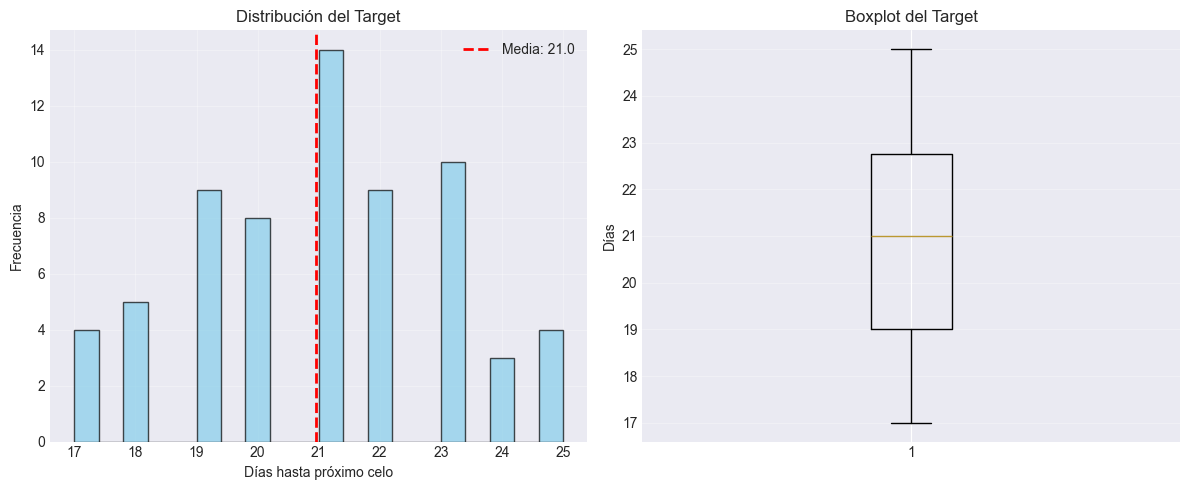


Estadísticas del target:
count    66.000000
mean     20.954545
std       2.122639
min      17.000000
25%      19.000000
50%      21.000000
75%      22.750000
max      25.000000
Name: days_to_next_heat, dtype: float64


In [91]:
# Verificar distribución del target
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_train[target_column], bins=20, edgecolor='black', alpha=0.7, color='skyblue')
plt.xlabel('Días hasta próximo celo')
plt.ylabel('Frecuencia')
plt.title('Distribución del Target')
plt.axvline(df_train[target_column].mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {df_train[target_column].mean():.1f}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(df_train[target_column])
plt.ylabel('Días')
plt.title('Boxplot del Target')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nEstadísticas del target:")
print(df_train[target_column].describe())



In [92]:
# Verificar que las columnas existen
print("Columnas disponibles en df_train:")
print(df_train.columns.tolist())

print("\nColumnas faltantes:")
missing = [col for col in feature_columns if col not in df_train.columns]
print(missing)

Columnas disponibles en df_train:
['id_x', 'cattle_id', 'heat_date', 'allows_mounting', 'vaginal_discharge', 'vulva_swelling', 'comportamiento', 'was_inseminated', 'insemination_date', 'pregnancy_confirmed', 'created_at', 'updated_at', 'id_y', 'birth_date', 'weight', 'fecha_ultimo_parto', 'breed', 'age_days', 'days_since_last_birth', 'next_heat_date', 'days_to_next_heat', 'prev_allows_mounting', 'prev_vaginal_discharge', 'prev_vulva_swelling', 'prev_comportamiento', 'prev_cycle_interval', 'avg_last_2_intervals', 'vaginal_discharge_encoded', 'vulva_swelling_encoded', 'comportamiento_encoded', 'breed_encoded', 'prev_vaginal_discharge_encoded', 'prev_vulva_swelling_encoded', 'prev_comportamiento_encoded', 'allows_mounting_int', 'prev_allows_mounting_int', 'was_inseminated_int']

Columnas faltantes:
['allows_mounting_lag1_int', 'vaginal_discharge_lag1_encoded', 'vulva_swelling_lag1_encoded', 'comportamiento_lag1_encoded', 'allows_mounting_lag2_int', 'vaginal_discharge_lag2_encoded', 'vulva

## 5. Análisis de Correlación

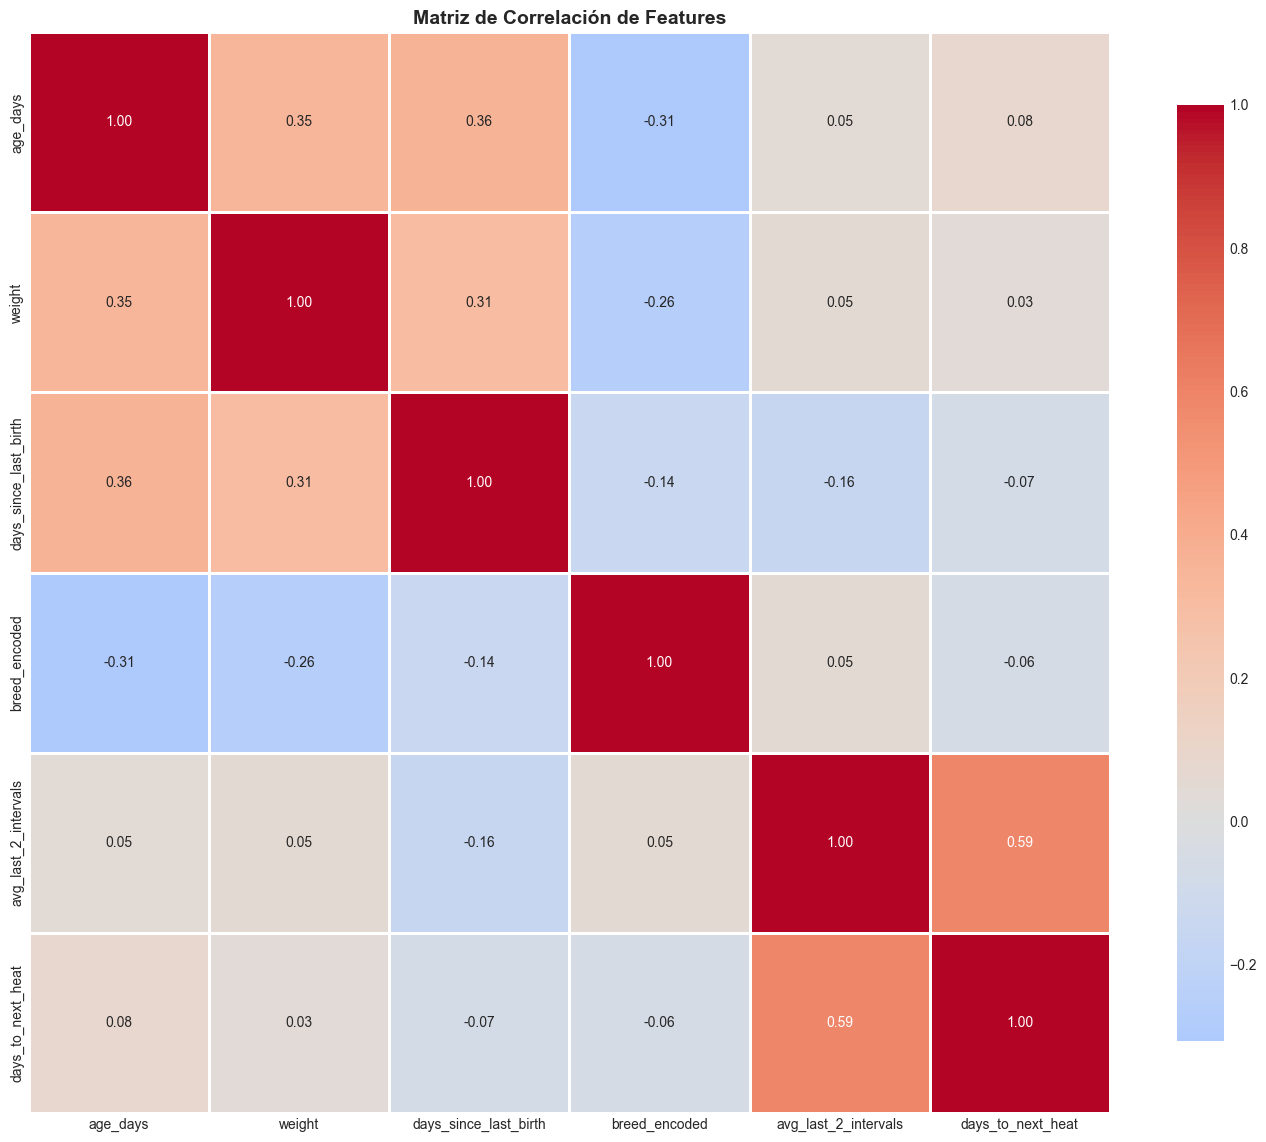


📊 Correlación con el target (days_to_next_heat):
days_to_next_heat        1.000000
avg_last_2_intervals     0.588353
age_days                 0.083703
weight                   0.032495
breed_encoded           -0.058016
days_since_last_birth   -0.067706
Name: days_to_next_heat, dtype: float64


In [93]:
# Matriz de correlación - solo con columnas que existen
available_features = [col for col in feature_columns if col in df_train.columns]
correlation_features = available_features + [target_column]
corr_matrix = df_train[correlation_features].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación de Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

target_corr = corr_matrix[target_column].sort_values(ascending=False)
print(f"\n📊 Correlación con el target ({target_column}):")
print(target_corr)



In [94]:
# Actualizar feature_columns para usar solo las disponibles
feature_columns = available_features

## 6. Preparar Train/Test Split

In [95]:
# Usar solo features disponibles
available_features = [col for col in feature_columns if col in df_train.columns]

print(f"📊 Features disponibles: {len(available_features)} de {len(feature_columns)}")
print(f"\nFeatures que SÍ existen:")
for feat in available_features:
    print(f"   - {feat}")

# Separar features y target
X = df_train[available_features].copy()
y = df_train[target_column].copy()

# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\n📊 División de datos:")
print(f"   - Train: {len(X_train)} registros")
print(f"   - Test: {len(X_test)} registros")
print(f"\nForma de X_train: {X_train.shape}")

📊 Features disponibles: 5 de 5

Features que SÍ existen:
   - age_days
   - weight
   - days_since_last_birth
   - breed_encoded
   - avg_last_2_intervals

📊 División de datos:
   - Train: 52 registros
   - Test: 14 registros

Forma de X_train: (52, 5)


## 7. Entrenar Modelo Random Forest

In [96]:
# Crear y entrenar Random Forest
print("🌲 Entrenando Random Forest Regressor...")

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

print("✅ Modelo Random Forest entrenado")

🌲 Entrenando Random Forest Regressor...
✅ Modelo Random Forest entrenado


In [97]:
# Predicciones
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

# Métricas
print("\n📊 MÉTRICAS RANDOM FOREST:")
print("\nTrain Set:")
print(f"   MAE: {mean_absolute_error(y_train, y_pred_train_rf):.2f} días")
print(f"   RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train_rf)):.2f} días")
print(f"   R²: {r2_score(y_train, y_pred_train_rf):.4f}")

print("\nTest Set:")
print(f"   MAE: {mean_absolute_error(y_test, y_pred_test_rf):.2f} días")
print(f"   RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test_rf)):.2f} días")
print(f"   R²: {r2_score(y_test, y_pred_test_rf):.4f}")


📊 MÉTRICAS RANDOM FOREST:

Train Set:
   MAE: 0.88 días
   RMSE: 1.07 días
   R²: 0.7224

Test Set:
   MAE: 1.62 días
   RMSE: 1.85 días
   R²: 0.3309


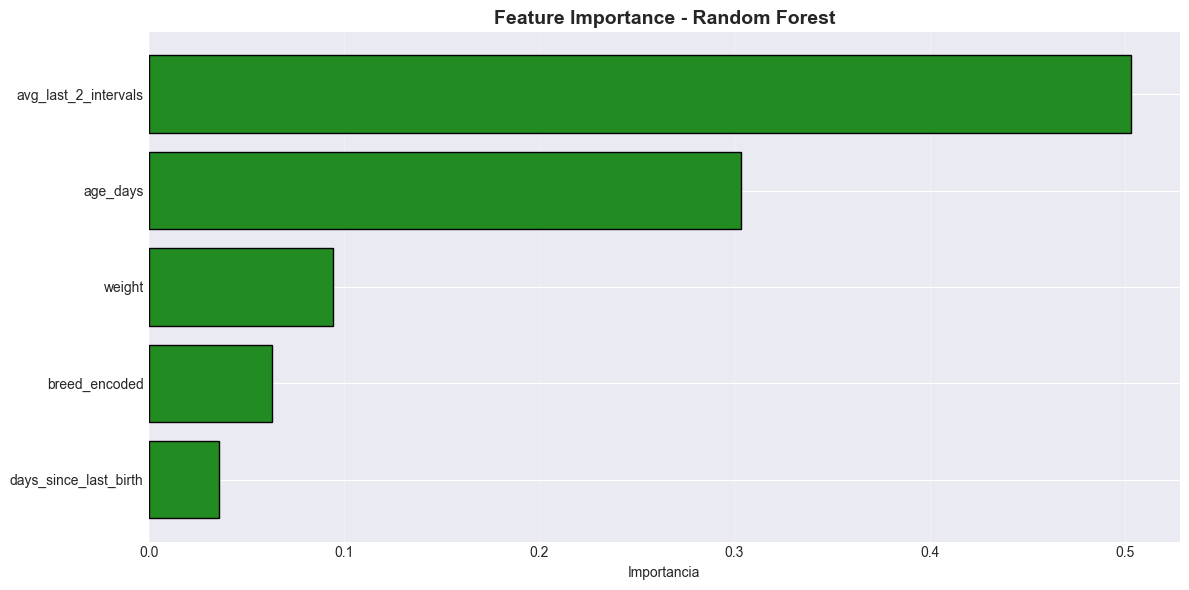


📊 Top 10 Features más importantes:
                 feature  importance
4   avg_last_2_intervals    0.503004
0               age_days    0.303411
1                 weight    0.094187
3          breed_encoded    0.063215
2  days_since_last_birth    0.036184


In [98]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(range(len(feature_importance)), feature_importance['importance'], color='forestgreen', edgecolor='black')
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Importancia')
plt.title('Feature Importance - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n📊 Top 10 Features más importantes:")
print(feature_importance.head(10))

## 8. Entrenar Modelo XGBoost

In [99]:
# Crear y entrenar XGBoost
print("🚀 Entrenando XGBoost Regressor...")

xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

print("✅ Modelo XGBoost entrenado")

🚀 Entrenando XGBoost Regressor...
✅ Modelo XGBoost entrenado


In [100]:
# Predicciones
y_pred_train_xgb = xgb_model.predict(X_train)
y_pred_test_xgb = xgb_model.predict(X_test)

# Métricas
print("\n📊 MÉTRICAS XGBOOST:")
print("\nTrain Set:")
print(f"   MAE: {mean_absolute_error(y_train, y_pred_train_xgb):.2f} días")
print(f"   RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train_xgb)):.2f} días")
print(f"   R²: {r2_score(y_train, y_pred_train_xgb):.4f}")

print("\nTest Set:")
print(f"   MAE: {mean_absolute_error(y_test, y_pred_test_xgb):.2f} días")
print(f"   RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test_xgb)):.2f} días")
print(f"   R²: {r2_score(y_test, y_pred_test_xgb):.4f}")


📊 MÉTRICAS XGBOOST:

Train Set:
   MAE: 0.07 días
   RMSE: 0.08 días
   R²: 0.9983

Test Set:
   MAE: 1.67 días
   RMSE: 1.83 días
   R²: 0.3459


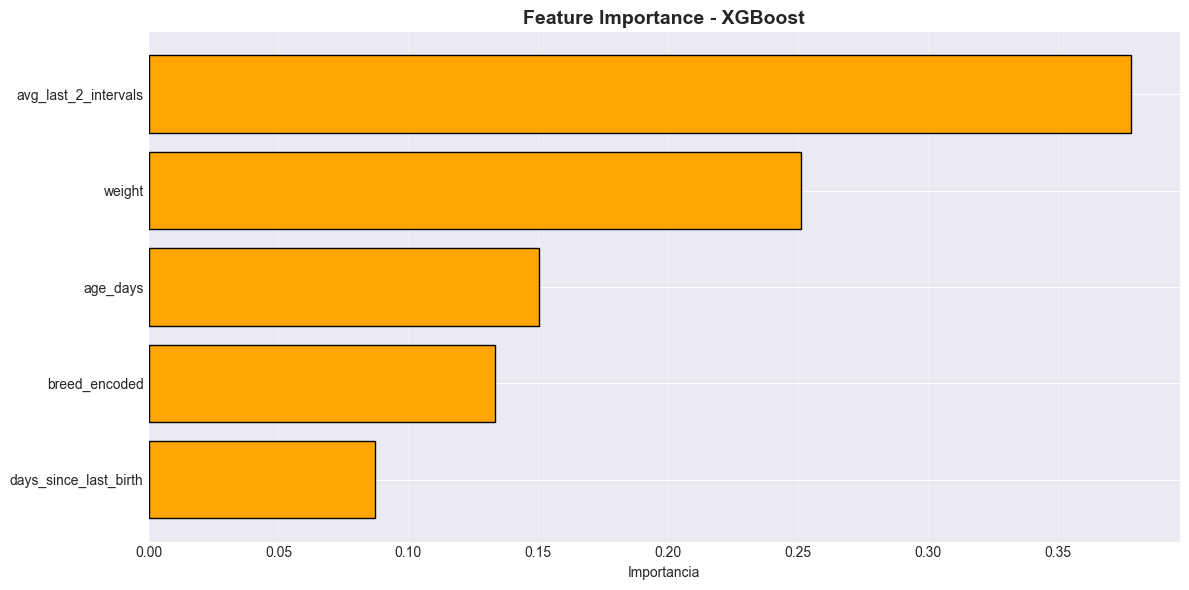


📊 Top 10 Features más importantes (XGBoost):
                 feature  importance
4   avg_last_2_intervals    0.378224
1                 weight    0.251059
0               age_days    0.150276
3          breed_encoded    0.133412
2  days_since_last_birth    0.087029


In [101]:
# Feature Importance XGBoost
xgb_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(range(len(xgb_importance)), xgb_importance['importance'], color='orange', edgecolor='black')
plt.yticks(range(len(xgb_importance)), xgb_importance['feature'])
plt.xlabel('Importancia')
plt.title('Feature Importance - XGBoost', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n📊 Top 10 Features más importantes (XGBoost):")
print(xgb_importance.head(10))

## 9. Comparación de Modelos

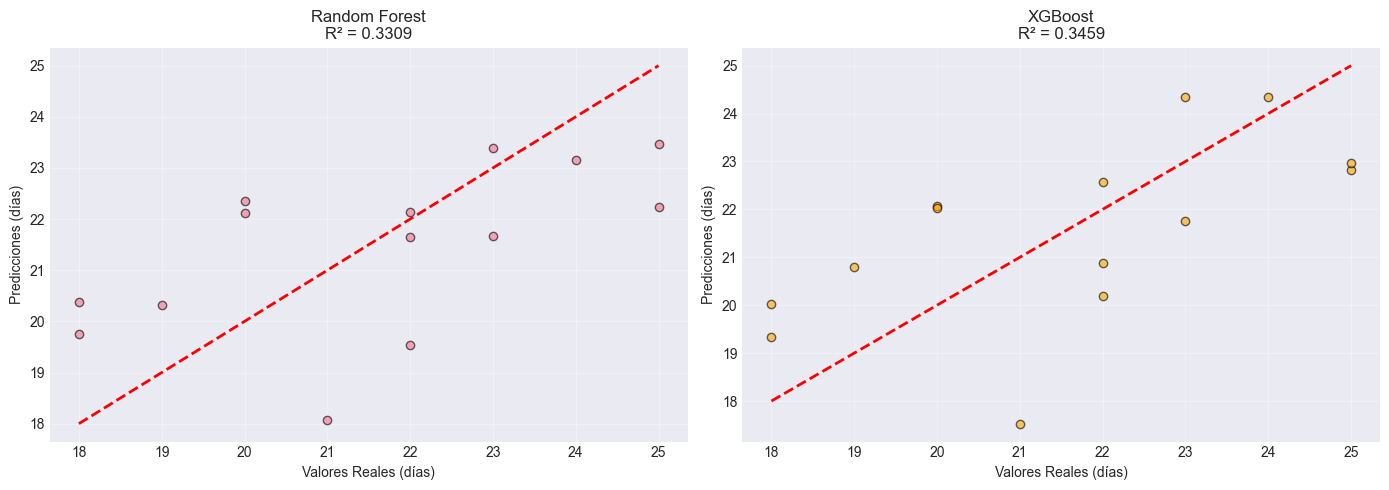

In [102]:
# Comparar predicciones vs valores reales
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Random Forest
axes[0].scatter(y_test, y_pred_test_rf, alpha=0.6, edgecolors='black')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Valores Reales (días)')
axes[0].set_ylabel('Predicciones (días)')
axes[0].set_title(f'Random Forest\nR² = {r2_score(y_test, y_pred_test_rf):.4f}')
axes[0].grid(True, alpha=0.3)

# XGBoost
axes[1].scatter(y_test, y_pred_test_xgb, alpha=0.6, color='orange', edgecolors='black')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Valores Reales (días)')
axes[1].set_ylabel('Predicciones (días)')
axes[1].set_title(f'XGBoost\nR² = {r2_score(y_test, y_pred_test_xgb):.4f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [103]:
# Tabla comparativa
comparison = pd.DataFrame({
    'Modelo': ['Random Forest', 'XGBoost'],
    'MAE (días)': [
        mean_absolute_error(y_test, y_pred_test_rf),
        mean_absolute_error(y_test, y_pred_test_xgb)
    ],
    'RMSE (días)': [
        np.sqrt(mean_squared_error(y_test, y_pred_test_rf)),
        np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
    ],
    'R²': [
        r2_score(y_test, y_pred_test_rf),
        r2_score(y_test, y_pred_test_xgb)
    ]
})

print("\n📊 COMPARACIÓN DE MODELOS:")
print(comparison.to_string(index=False))

# Determinar mejor modelo
best_model_idx = comparison['MAE (días)'].idxmin()
best_model_name = comparison.loc[best_model_idx, 'Modelo']
print(f"\n✅ Mejor modelo: {best_model_name}")


📊 COMPARACIÓN DE MODELOS:
       Modelo  MAE (días)  RMSE (días)       R²
Random Forest    1.615850     1.847582 0.330943
      XGBoost    1.668002     1.826815 0.345898

✅ Mejor modelo: Random Forest


## 10. Predicción para una Vaca Específica

In [104]:
# Seleccionar una vaca para predicción
test_cattle_id = df_train['cattle_id'].iloc[0]

# Obtener último registro de celo de esa vaca
cattle_history = df_train[df_train['cattle_id'] == test_cattle_id].sort_values('heat_date')
last_heat = cattle_history.iloc[-1]

print(f"\n🐄 Vaca seleccionada: {test_cattle_id}")
print(f"\n📋 Último celo registrado:")
print(f"   Fecha: {last_heat['heat_date'].date()}")
print(f"   Edad: {last_heat['age_days']} días")
print(f"   Peso: {last_heat['weight']:.1f} kg")
print(f"   Allows mounting: {bool(last_heat['allows_mounting'])}")
print(f"   Vaginal discharge: {last_heat['vaginal_discharge']}")
print(f"   Vulva swelling: {last_heat['vulva_swelling']}")
print(f"   Comportamiento: {last_heat['comportamiento']}")


🐄 Vaca seleccionada: 08ed8a86-49ae-4f9d-9a8a-5247a50b4f0b

📋 Último celo registrado:
   Fecha: 2025-06-09
   Edad: 445.0 días
   Peso: 495.0 kg
   Allows mounting: True
   Vaginal discharge: seco
   Vulva swelling: alta
   Comportamiento: mugido


In [105]:
# Preparar features para predicción
X_predict = last_heat[feature_columns].to_frame().T
X_predict = X_predict.astype(float)
# Predicción con ambos modelos
pred_rf = rf_model.predict(X_predict)[0]
pred_xgb = xgb_model.predict(X_predict)[0]
pred_avg = (pred_rf + pred_xgb) / 2

# Calcular fecha estimada
next_heat_date_rf = last_heat['heat_date'] + timedelta(days=int(pred_rf))
next_heat_date_xgb = last_heat['heat_date'] + timedelta(days=int(pred_xgb))
next_heat_date_avg = last_heat['heat_date'] + timedelta(days=int(pred_avg))

print(f"\n🔮 PREDICCIONES:")
print(f"\nRandom Forest:")
print(f"   Días hasta próximo celo: {pred_rf:.1f}")
print(f"   Fecha estimada: {next_heat_date_rf.date()}")

print(f"\nXGBoost:")
print(f"   Días hasta próximo celo: {pred_xgb:.1f}")
print(f"   Fecha estimada: {next_heat_date_xgb.date()}")

print(f"\nPromedio (Ensemble):")
print(f"   Días hasta próximo celo: {pred_avg:.1f}")
print(f"   Fecha estimada: {next_heat_date_avg.date()}")

# Valor real si existe
if pd.notna(last_heat['days_to_next_heat']):
    print(f"\n✅ Valor real: {last_heat['days_to_next_heat']:.1f} días")
    print(f"   Error RF: {abs(pred_rf - last_heat['days_to_next_heat']):.1f} días")
    print(f"   Error XGB: {abs(pred_xgb - last_heat['days_to_next_heat']):.1f} días")


🔮 PREDICCIONES:

Random Forest:
   Días hasta próximo celo: 22.4
   Fecha estimada: 2025-07-01

XGBoost:
   Días hasta próximo celo: 24.8
   Fecha estimada: 2025-07-03

Promedio (Ensemble):
   Días hasta próximo celo: 23.6
   Fecha estimada: 2025-07-02

✅ Valor real: 25.0 días
   Error RF: 2.6 días
   Error XGB: 0.2 días


## 11. Predicción para Todas las Vacas

In [106]:
# Obtener último registro de cada vaca
last_heats = df_merged.sort_values('heat_date').groupby('cattle_id').last().reset_index()

# Filtrar vacas con datos completos
last_heats = last_heats.dropna(subset=feature_columns)

if len(last_heats) > 0:
    # Predicciones
    X_all = last_heats[feature_columns]
    predictions_rf = rf_model.predict(X_all)
    predictions_xgb = xgb_model.predict(X_all)
    predictions_avg = (predictions_rf + predictions_xgb) / 2
    
    # Crear dataframe de resultados
    results = pd.DataFrame({
        'cattle_id': last_heats['cattle_id'],
        'last_heat_date': last_heats['heat_date'].dt.date,
        'predicted_days_rf': predictions_rf.round(1),
        'predicted_days_xgb': predictions_xgb.round(1),
        'predicted_days_avg': predictions_avg.round(1)
    })
    
    results['next_heat_date'] = pd.to_datetime(results['last_heat_date']) + pd.to_timedelta(results['predicted_days_avg'], unit='D')
    results['days_until_heat'] = (results['next_heat_date'] - pd.Timestamp.now()).dt.days
    
    # Ordenar por proximidad
    results = results.sort_values('days_until_heat')
    
    print(f"\n📊 Predicciones para {len(results)} vacas:")
    print(results.head(10))
    
    # Guardar resultados
    results.to_csv('multimodal_heat_predictions.csv', index=False)
    print("\n✅ Resultados guardados en: multimodal_heat_predictions.csv")
else:
    print("⚠️ No hay suficientes datos para predicción")


📊 Predicciones para 19 vacas:
                               cattle_id last_heat_date  predicted_days_rf  \
6   22f18598-8f34-497d-8684-fafe93e51a63     2025-11-25               18.5   
2   0dae6431-8455-4b19-a3bd-6b99dc74b33b     2025-11-23               21.3   
11  43455f44-0470-4aa1-aef6-e3f7125ce09a     2025-11-24               21.0   
17  80683f50-08e3-4bd4-9040-2e0518c3577e     2025-11-28               19.8   
19  a0babefa-4124-41bc-a5bf-9cf851c7dcbd     2025-11-25               22.7   
18  973ecddc-f079-4ef4-8748-0ade370c7713     2025-11-27               23.0   
7   23261ffb-ece8-4af9-95ec-7e43ea6a964a     2025-11-29               21.9   
3   0ee61ad6-c79c-4b6f-ab63-2739b6609a52     2025-11-27               23.5   
28  e36acfdc-e6c2-46e1-8ab5-576b8308808d     2025-12-01               19.8   
22  bbe2bf41-cc47-47a3-a20a-7dec7e7faf49     2025-12-02               20.2   

    predicted_days_xgb  predicted_days_avg      next_heat_date  \
6            17.799999                18.2 2


🚨 Vacas con celo próximo (≤7 días): 11
                               cattle_id      next_heat_date  days_until_heat
6   22f18598-8f34-497d-8684-fafe93e51a63 2025-12-13 04:48:00               -2
2   0dae6431-8455-4b19-a3bd-6b99dc74b33b 2025-12-14 02:24:00               -1
11  43455f44-0470-4aa1-aef6-e3f7125ce09a 2025-12-14 19:12:00               -1
17  80683f50-08e3-4bd4-9040-2e0518c3577e 2025-12-17 12:00:00                2
19  a0babefa-4124-41bc-a5bf-9cf851c7dcbd 2025-12-17 21:36:00                2
18  973ecddc-f079-4ef4-8748-0ade370c7713 2025-12-20 00:00:00                4
7   23261ffb-ece8-4af9-95ec-7e43ea6a964a 2025-12-21 00:00:00                5
3   0ee61ad6-c79c-4b6f-ab63-2739b6609a52 2025-12-20 09:36:00                5
28  e36acfdc-e6c2-46e1-8ab5-576b8308808d 2025-12-21 09:36:00                6
22  bbe2bf41-cc47-47a3-a20a-7dec7e7faf49 2025-12-22 02:24:00                7
24  c29c51d0-1a28-48c5-be04-9a19caf32a55 2025-12-22 14:24:00                7


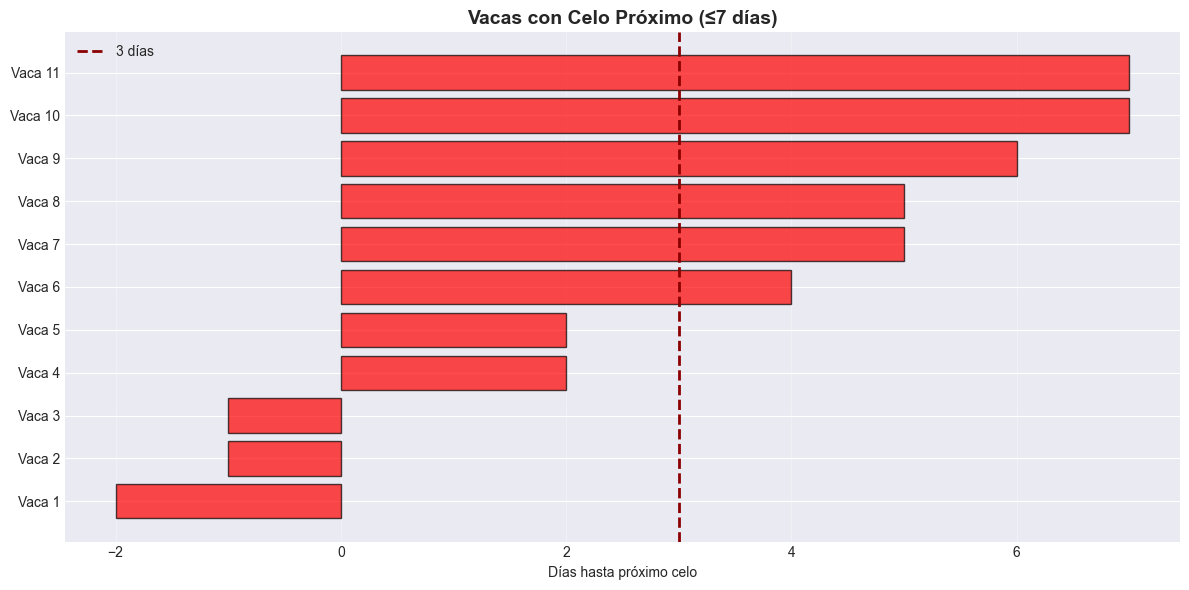

In [107]:
# Visualizar vacas con celo próximo
if len(results) > 0:
    upcoming = results[results['days_until_heat'] <= 7]
    
    if len(upcoming) > 0:
        print(f"\n🚨 Vacas con celo próximo (≤7 días): {len(upcoming)}")
        print(upcoming[['cattle_id', 'next_heat_date', 'days_until_heat']])
        
        plt.figure(figsize=(12, 6))
        plt.barh(range(len(upcoming)), upcoming['days_until_heat'], color='red', edgecolor='black', alpha=0.7)
        plt.yticks(range(len(upcoming)), [f"Vaca {i+1}" for i in range(len(upcoming))])
        plt.xlabel('Días hasta próximo celo')
        plt.title('Vacas con Celo Próximo (≤7 días)', fontsize=14, fontweight='bold')
        plt.axvline(3, color='darkred', linestyle='--', linewidth=2, label='3 días')
        plt.grid(True, alpha=0.3, axis='x')
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("\n✅ No hay vacas con celo próximo en los próximos 7 días")

## 12. Análisis de Errores

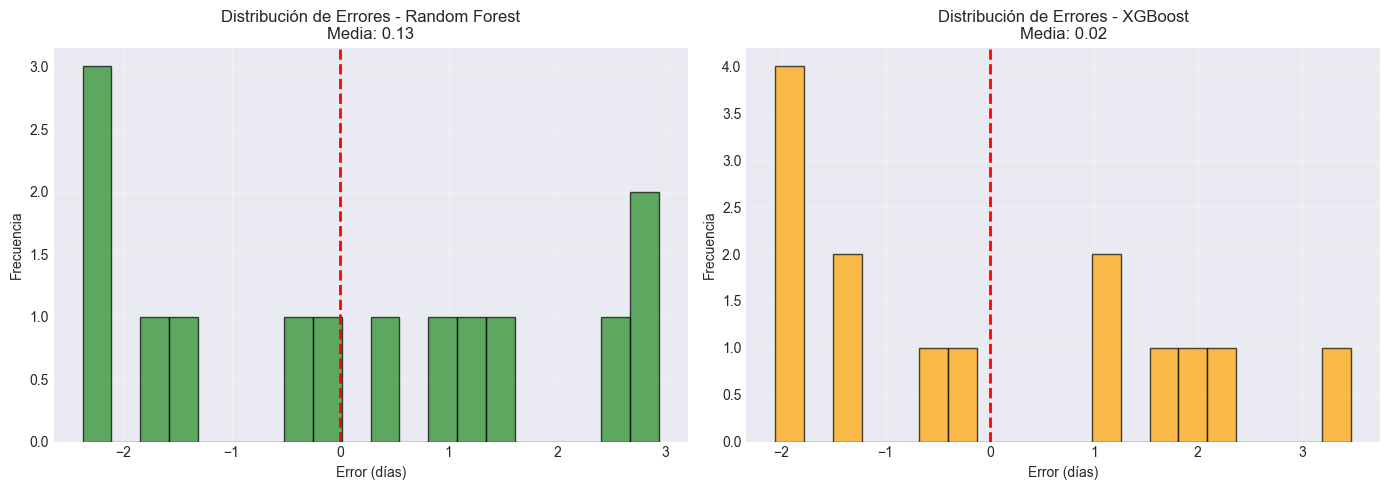


📊 Análisis de Errores:

Random Forest:
   Error promedio: 0.13 días
   Desviación estándar: 1.91 días

XGBoost:
   Error promedio: 0.02 días
   Desviación estándar: 1.90 días


In [108]:
# Calcular errores
errors_rf = y_test - y_pred_test_rf
errors_xgb = y_test - y_pred_test_xgb

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribución de errores RF
axes[0].hist(errors_rf, bins=20, edgecolor='black', alpha=0.7, color='forestgreen')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Error (días)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title(f'Distribución de Errores - Random Forest\nMedia: {errors_rf.mean():.2f}')
axes[0].grid(True, alpha=0.3)

# Distribución de errores XGBoost
axes[1].hist(errors_xgb, bins=20, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Error (días)')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title(f'Distribución de Errores - XGBoost\nMedia: {errors_xgb.mean():.2f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Análisis de Errores:")
print(f"\nRandom Forest:")
print(f"   Error promedio: {errors_rf.mean():.2f} días")
print(f"   Desviación estándar: {errors_rf.std():.2f} días")

print(f"\nXGBoost:")
print(f"   Error promedio: {errors_xgb.mean():.2f} días")
print(f"   Desviación estándar: {errors_xgb.std():.2f} días")

## 13. Resumen Final

In [109]:
print("="*70)
print(" " * 20 + "RESUMEN FINAL")
print("="*70)

print(f"\n📊 DATASET:")
print(f"   - Total de registros entrenamiento: {len(df_train)}")
print(f"   - Features utilizadas: {len(feature_columns)}")
print(f"   - Train/Test split: {len(X_train)}/{len(X_test)}")

print(f"\n🤖 MODELOS ENTRENADOS:")
print(f"   - Random Forest")
print(f"   - XGBoost")

print(f"\n📈 PERFORMANCE (Test Set):")
print(f"\n   Random Forest:")
print(f"      MAE: {mean_absolute_error(y_test, y_pred_test_rf):.2f} días")
print(f"      RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test_rf)):.2f} días")
print(f"      R²: {r2_score(y_test, y_pred_test_rf):.4f}")

print(f"\n   XGBoost:")
print(f"      MAE: {mean_absolute_error(y_test, y_pred_test_xgb):.2f} días")
print(f"      RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test_xgb)):.2f} días")
print(f"      R²: {r2_score(y_test, y_pred_test_xgb):.4f}")

print(f"\n✅ MODELO RECOMENDADO: {best_model_name}")

print(f"\n💡 FEATURES MÁS IMPORTANTES (Top 5):")
if best_model_name == 'Random Forest':
    top_features = feature_importance.head(5)
else:
    top_features = xgb_importance.head(5)

for idx, row in top_features.iterrows():
    print(f"   {row['feature']}: {row['importance']:.4f}")

print("\n" + "="*70)

                    RESUMEN FINAL

📊 DATASET:
   - Total de registros entrenamiento: 66
   - Features utilizadas: 5
   - Train/Test split: 52/14

🤖 MODELOS ENTRENADOS:
   - Random Forest
   - XGBoost

📈 PERFORMANCE (Test Set):

   Random Forest:
      MAE: 1.62 días
      RMSE: 1.85 días
      R²: 0.3309

   XGBoost:
      MAE: 1.67 días
      RMSE: 1.83 días
      R²: 0.3459

✅ MODELO RECOMENDADO: Random Forest

💡 FEATURES MÁS IMPORTANTES (Top 5):
   avg_last_2_intervals: 0.5030
   age_days: 0.3034
   weight: 0.0942
   breed_encoded: 0.0632
   days_since_last_birth: 0.0362



## Conclusiones

Este notebook demuestra ML Multimodal REAL:

1. **Múltiples features** de diferentes tipos:
   - Síntomas del celo actual
   - Características de la vaca (edad, peso, raza)
   - Historial reproductivo
   - Features del celo anterior (lag)

2. **Modelos entrenados**:
   - Random Forest: Robusto, interpretable
   - XGBoost: Alta precisión, maneja relaciones complejas

3. **Ventajas sobre promedio simple**:
   - Considera patrones individuales de cada vaca
   - Aprende relaciones no lineales
   - Usa TODA la información disponible

4. **Mejoras futuras**:
   - Más datos históricos
   - Tuning de hiperparámetros
   - Features adicionales de salud
   - Ensemble de múltiples modelos